In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import text2synth

import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

In [13]:
# Constants
F0 = 344.0  # fundamental frequency
DURATION = 1.1  # [seconds]
SAMPLE_RATE = 16_000  # [Hz]
NUM_FRAMES = int(DURATION * SAMPLE_RATE)

# Sample frequency inputs
F0_FULL = torch.full((1, NUM_FRAMES), F0, dtype=torch.float64, requires_grad=True)

def plot(freq, waveform, sample_rate, zoom=False, vol=0.1):
    """
    Plot frequency, waveform, and spectrogram information (as well as audio playback).
    Args:
        freq: Tensor of shape (time), in Hz.
        waveform: Tensor of shape (time) in amplitude (?).
        sample_rate: Float in Hz.
        zoom: Boolean to display "zoomed" in waveform.
        vol: Float [0,1] (WARNING: keep low, gets loud).
    """
    freq = freq.detach()
    waveform = waveform.detach()
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(3, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title="Waveform", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, waveform)
    axes[1].set(ylabel="Waveform")
    axes[2].specgram(waveform, Fs=sample_rate)
    axes[2].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(3):
        axes[i].grid(True)
    pos = axes[2].get_position()
    fig.tight_layout()

    if zoom:
        ax = fig.add_axes([pos.x0 + 0.02, pos.y0 + 0.32, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=(1 / F0, 3 / F0), xticks=[], yticks=[])

    waveform /= waveform.abs().max()
    return ipd.Audio(vol * waveform, rate=sample_rate, normalize=False)

def plot_envelope(t, envelope):
    plt.plot(t.detach()[0], envelope.detach().numpy()[0])
    plt.title("Amplifier Envelope")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

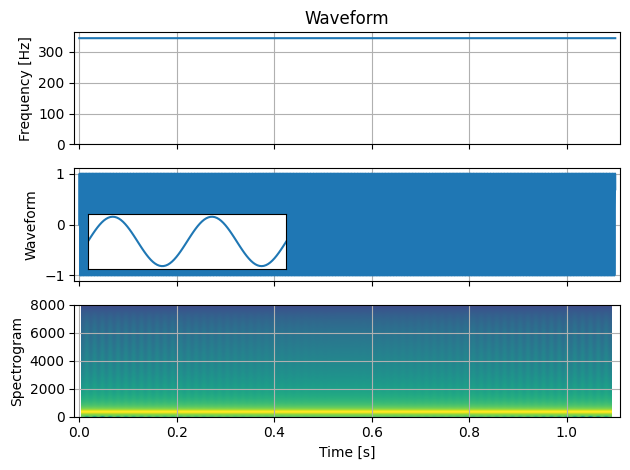

In [14]:
# Sinusoidal Oscillator
sin_osc = text2synth.SinOscillator(SAMPLE_RATE)
plot(F0_FULL[0], sin_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

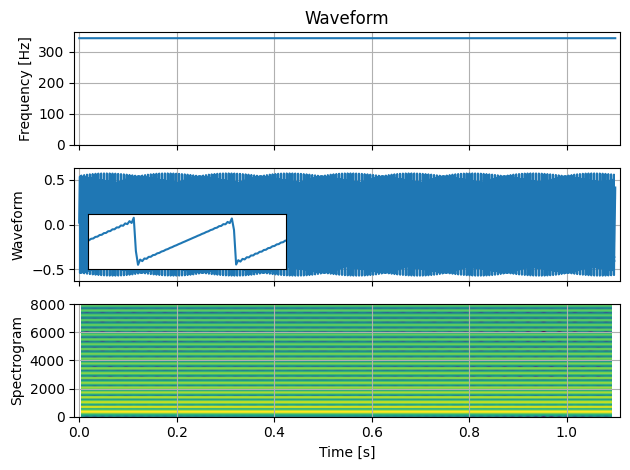

In [15]:
saw_osc = text2synth.SawtoothOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], saw_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

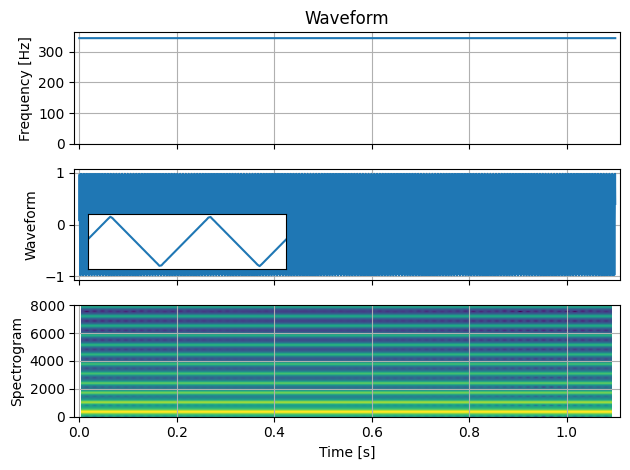

In [16]:
tri_osc = text2synth.TriangleOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], tri_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

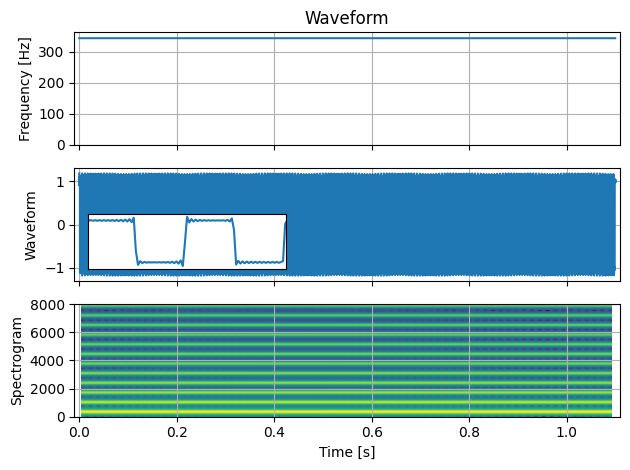

In [17]:
sq_osc = text2synth.SquareOscillator(SAMPLE_RATE, int(SAMPLE_RATE / F0))
plot(F0_FULL[0], sq_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

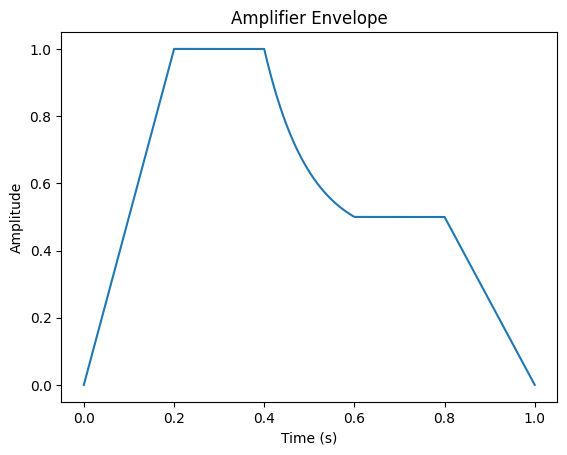

In [18]:
amp_env = text2synth.AmpEnvelope(2)
amp_params = amp_env.get_params_dict(0.2, 0.2, 0.2, 0.5, 0.2, requires_grad=True)

t = torch.linspace(0,1.0,F0_FULL.shape[1]).unsqueeze(0)
plot_envelope(t, amp_env.get_envelope(t, amp_params))

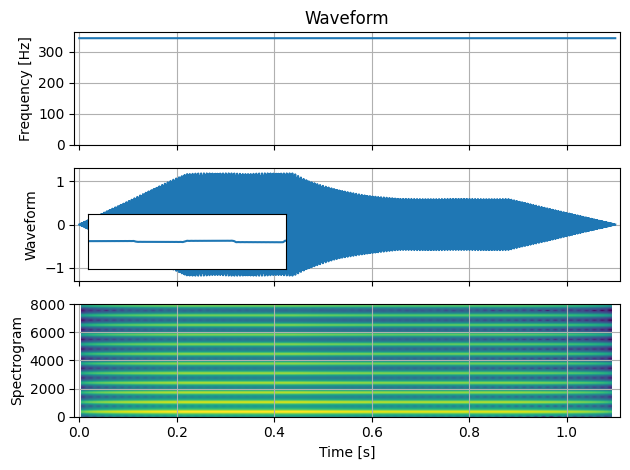

In [19]:
sample_wav = amp_env(sq_osc(F0_FULL), amp_params)
plot(F0_FULL[0], sample_wav[0], SAMPLE_RATE, zoom=True)

In [20]:
# Backwards
F0_FULL = torch.full((1, NUM_FRAMES), F0, dtype=torch.float64, requires_grad=True)
amp_params = amp_env.get_params_dict(0.05, 0.02, 0.9, 0.05, 0.02, requires_grad=True)

output = amp_env(sq_osc(F0_FULL), amp_params)
loss = torch.mean((output - sample_wav) ** 2)
loss.backward()
print(F0_FULL.grad)
for k,v in amp_params.items():
    print("{}: {}".format(k, v.grad))

tensor([[ 5.8913e-10,  5.8913e-10,  5.8911e-10,  ..., -1.4295e-16,
          8.2005e-17, -2.8130e-18]], dtype=torch.float64)
a: -0.685111403465271
h: -0.1675744354724884
d: -0.13940013945102692
s: -0.2511756420135498
r: -0.0002475731889717281
